In [1]:
import numpy as np
from docplex.mp.model import Model
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from openqaoa import QAOA
import time
from openqaoa.problems.converters import FromDocplex2IsingModel

In [2]:
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

%matplotlib inline

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 3))  # Adjust the power limits as needed


mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.autolayout'] = False
# mpl.rcParams['figure.figsize'] = 10,7
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['lines.markeredgewidth'] = 1.1
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
colors = '#0071bc #f5b34c #00a76d #ed1c24 #00c0f3 #80c342 #a066aa #9f184c #f69795 #ff781f #6e692a #6d6e70 #000000'.split()

In [9]:
def constraint_1(sol, asset, n_accounts, n_binary, kind="binary"):
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]
    const_1 = 0
    for j in range(n_accounts):
        for b in range(n_binary):
            if f"Q_{asset}_{j}^{b}" in sol.keys() and sol[f"Q_{asset}_{j}^{b}"]:
                const_1 += bin_coef[b]
    return const_1 <= 1

def constraint_2(sol, account, n_assets, n_binary, asset_quantity, asset_value, haircuts, account_exposure, kind="binary"):
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]
    const_2 = 0
    for i in range(n_assets):
        for b in range(n_binary):
            if f"Q_{i}_{account}^{b}" in sol.keys() and sol[f"Q_{i}_{account}^{b}"]:
                const_2 += bin_coef[b]*asset_quantity[i]*asset_value[i]*(haircuts[i][account]/100)
    return const_2 >= account_exposure[account]

def solution_allocation(sol, n_binary, n_assets, n_accounts, account_duration, kind="binary"):
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]
    sol_short = defaultdict(float)
    sol_long = defaultdict(float)

    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                if f"Q_{i}_{j}^{b}" in sol.keys() and sol[f"Q_{i}_{j}^{b}"]:
                    if account_duration[j]:
                        sol_short[f"Q_{i}"] += bin_coef[b]
                    else:
                        sol_long[f"Q_{i}"] += bin_coef[b]
                else:
                    sol_long[f"Q_{i}"] += 0
                    sol_short[f"Q_{i}"] += 0
    return {"short":sol_short, "long":sol_long}

def solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind="binary"):
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/(n_binary - 1) for n in range(n_binary)]
    account = defaultdict(dict)
    for j in range(n_accounts):
        for i in range(n_assets):
            account[j][i] = 0
            for b in range(n_binary):
                if f"Q_{i}_{j}^{b}" in sol.keys() and sol[f"Q_{i}_{j}^{b}"]:
                    account[j][i] += bin_coef[b]*asset_quantity[i]*asset_value[i]*(haircuts[i][j]/100)
    return account

def collateral_opt(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind="binary"):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]

    mdl.minimize(cost)

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        mdl.add_constraint(mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)) <= 1)
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
#         val = np.mean([v*q for v, q in zip(asset_value,asset_quantity)])
        mdl.add_constraint(mdl.sum(bin_coef[b]*asset_quantity[i]*asset_value[i]*
                                   (haircuts[i][j]/100)* Q[i][j][b]/account_exposure[j]
                                   for b in range(n_binary) for i in range(n_assets)) >= 1)
    return mdl

def collateral_opt_2(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma, kind="binary"):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * (bin_coef[bi] + bin_coef[bk]) * Q[k][j][bk] * Q[i][j][bi]
    mdl.minimize(cost)

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        mdl.add_constraint(mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)) <= 1)
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
#         val = np.mean([v*q for v, q in zip(asset_value,asset_quantity)])
        mdl.add_constraint(mdl.sum(bin_coef[b]*asset_quantity[i]*asset_value[i]*
                                   (haircuts[i][j]/100)* Q[i][j][b]/account_exposure[j]
                                   for b in range(n_binary) for i in range(n_assets)) >= 1)
    return mdl


def collateral_opt_unb(lambdas, n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind="binary"):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    # Updated Tier list 
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        h1 = (1 - mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)))
        cost -= lambdas[0] * h1
        cost += lambdas[1] * h1**2
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
        h2 = (mdl.sum(min(bin_coef[b]*asset_quantity[i]*asset_value[i]/account_exposure[j], 1)*
                           (haircuts[i][j]/100) * Q[i][j][b]
                           for b in range(n_binary) for i in range(n_assets)) - 1)
        cost -= lambdas[2] * h2
        cost += lambdas[3] * h2 ** 2
    mdl.minimize(cost)
    return mdl

def collateral_opt_unb_2(lambdas, n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind="binary"):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    # Updated Tier list 
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * (bin_coef[bi] + bin_coef[bk]) * Q[k][j][bk] * Q[i][j][bi]

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        h1 = (1 - mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)))
        cost -= lambdas[0] * h1
        cost += lambdas[1] * h1**2
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
        h2 = (mdl.sum(min(bin_coef[b]*asset_quantity[i]*asset_value[i]/account_exposure[j], 1)*
                           (haircuts[i][j]/100) * Q[i][j][b]
                           for b in range(n_binary) for i in range(n_assets)) - 1)
        cost -= lambdas[2] * h2
        cost += lambdas[3] * h2 ** 2
    mdl.minimize(cost)
    return mdl


def get_cost(sol, n_binary, account_duration, asset_tiers, kind="binary"):
    if kind == "binary":
        bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]
    elif kind == "linear":
        bin_coef = [1/n_binary for n in range(n_binary)]
    n_assets = len(asset_tiers)
    n_accounts = len(account_duration)
    
    # Updated Tier list 
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                if f"Q_{i}_{j}^{b}" in sol.keys() and sol[f"Q_{i}_{j}^{b}"]:
                    cost += bin_coef[b] * (Omega[i][j])
    return cost

def classical_solution(mdl, string: bool = False, solution_limit = 100):
    """
    Return the classical solution of the maximal independent set problem
    Parameters
    ----------
    string : bool, optional
        If the solution is returned as a string. The default is False.
    Raises
    ------
    ValueError
        A flag if docplex does not find a valid solution.
    Returns
    -------
    solution : Union[str, dict]
        The classical solution of the specific problem as a string or a dict.
    """
    model = mdl.copy()
    decision_variables = [var for var in model.iter_binary_vars()]
    # Define decision variables, constraints, and the objective function
    # ... (Define your problem here) ...

    # Initialize a list to store all optimal solutions
    optimal_solutions = []

    # Initialize a counter to limit the number of solutions (optional)
      # You can set a desired limit
    energy = 1000
    while True:
        # Solve the current model
        model.solve()
        if round(model.solution.get_objective_value(),8) <= energy:
            energy = round(model.solution.get_objective_value(), 8)
            if energy == 0:
                break
        else:
            break
        # Check if a solution is found
        if model.solution is not None:
            
            # Store the current optimal solution
            optimal_solutions.append("".join(str(round(model.solution.get_value(var))) for var in decision_variables))

            # Add a cut to exclude the current solution
            sol = [var for var in decision_variables if round(model.solution.get_value(var)) == 1] 
            cut = model.sum(sol) <= len(sol) - 1
            model.add_constraint(cut)
        else:
            # No more solutions found
            break

        # You can add additional termination conditions, such as reaching a solution limit

        if len(optimal_solutions) >= solution_limit:
            break
    return optimal_solutions

In [113]:
def collateral_opt_3(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    bin_coef = n_binary * (n_binary - 1) / 2 + n_binary

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]

    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for bi in range(n_binary):
                for bj in range(bi, n_binary):
                    cost += (1/bin_coef) * (Omega[i][j]) * Q[i][j][bi] * Q[i][j][bj]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += (1/bin_coef) * sigma[i][k] * Q[k][j][bk] * Q[i][j][bi]
    mdl.minimize(cost)

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        mdl.add_constraint(mdl.sum((1/bin_coef) * Q[i][j][bi] * Q[i][j][bj] for bi in range(n_binary) for bj in range(bi, n_binary) for j in range(n_accounts)) <= 1)
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
#         val = np.mean([v*q for v, q in zip(asset_value,asset_quantity)])
        mdl.add_constraint(mdl.sum((1/bin_coef)*asset_quantity[i]*asset_value[i]*
                                   (haircuts[i][j]/100)* Q[i][j][bi] * Q[i][j][bj]/account_exposure[j]
                                   for bi in range(n_binary) for bj in range(bi, n_binary) for i in range(n_assets)) >= 1)
    return mdl

def collateral_opt_4(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    bin_coef = [1/n_binary for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * (bin_coef[bi] + bin_coef[bk]) * Q[k][j][bk] * Q[i][j][bi]
    mdl.minimize(cost)

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        mdl.add_constraint(mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)) <= 1)
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
#         val = np.mean([v*q for v, q in zip(asset_value,asset_quantity)])
        mdl.add_constraint(mdl.sum(bin_coef[b]*asset_quantity[i]*asset_value[i]*
                                   (haircuts[i][j]/100)* Q[i][j][b]/account_exposure[j]
                                   for b in range(n_binary) for i in range(n_assets)) >= 1)
    return mdl

def collateral_opt_unb_3(lambdas, n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts):
    # The new variables implementation
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    # Updated Tier list 
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * (bin_coef[bi] + bin_coef[bk]) * Q[k][j][bk] * Q[i][j][bi]

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        h1 = (1 - mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)))
        cost -= lambdas[0] * h1
        cost += lambdas[1] * h1**2
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
        h2 = (mdl.sum(min(bin_coef[b]*asset_quantity[i]*asset_value[i]/account_exposure[j], 1)*
                           (haircuts[i][j]/100) * Q[i][j][b]
                           for b in range(n_binary) for i in range(n_assets)) - 1)
        cost -= lambdas[2] * h2
        cost += lambdas[3] * h2 ** 2
    mdl.minimize(cost)
    return mdl

## Input data

In [10]:
# Input data 

# Assets
asset_quantity = pd.read_csv("data/sample_asset_quantity.csv", header=None)[0].values.tolist()
asset_value = pd.read_csv("data/sample_asset_value.csv", header=None)[0].values.tolist()
asset_tiers = pd.read_csv("data/sample_asset_tiers.csv", header=None)[0].values.tolist()

n_assets = len(asset_quantity)

# Accounts 
account_exposure = pd.read_csv("data/sample_account_exposure.csv", header=None)[0].values.tolist()
account_duration = pd.read_csv("data/sample_account_duration.csv", header=None)[0].values.tolist()

n_accounts = len(account_exposure)

# Haircuts
haircuts = (pd.read_csv("data/sample_haircuts.csv", header=None).values.tolist())

print(f"Num. assets: {n_assets}, num. accounts: {n_accounts}")

Num. assets: 10, num. accounts: 5


## Collateral Optimization: CPLEX solution 

In [31]:
Qmax = 1
Qmin = 0
kind = "linear"
opt_sols = {}
for n_binary in range(1,11):
    print(f"----------- binary terms:{n_binary} -------------")
    mdl = collateral_opt(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind=kind)
#     mdl.prettyprint()
    mdl.solve()
    sol = {name.name:value for name, value in mdl.solution.as_dict().items()}
    print("Cost: ", get_cost(sol, n_binary, account_duration, asset_tiers, kind=kind))
    print("Satisfied all constriants 1: ", all([constraint_1(sol, i, n_accounts, n_binary, kind=kind) for i in range(n_assets)]))
    print("Satisfied all constriants 2: ", all([constraint_2(sol, j, n_assets, n_binary, asset_quantity,
              asset_value, haircuts, account_exposure, kind=kind) for j in range(n_accounts)]))
    opt_sols[n_binary] = mdl.objective_value

----------- binary terms:1 -------------


Cost:  1.5
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:2 -------------
Cost:  0.7
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:3 -------------
Cost:  0.6666666666666666
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:4 -------------
Cost:  0.5249999999999999
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:5 -------------
Cost:  0.5199999999999999
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:6 -------------
Cost:  0.49999999999999994
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:7 -------------
Cost:  0.5000000000000001
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
----------- binary terms:8 -------------
Cost:  0.5000000000000001
Satisfied all constriants 1:  True
Satisfied

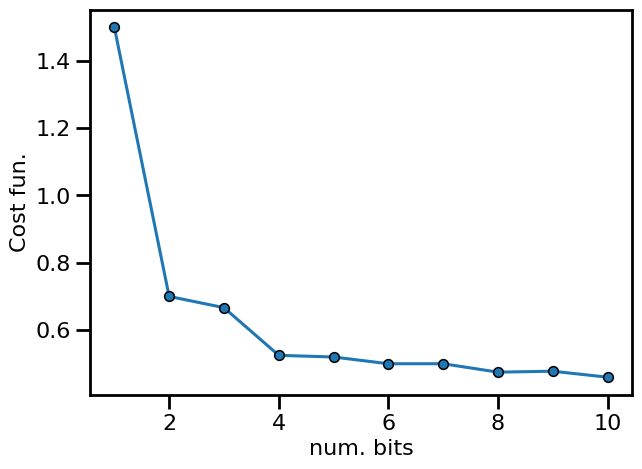

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(opt_sols.keys(), opt_sols.values(), marker="o", markeredgecolor="black")
ax.set_xlabel("num. bits")
ax.set_ylabel("Cost fun.")
fig.savefig("./Figures/cost_vs_bits.png", bbox_inches="tight")

In [33]:
n_binary = 15
mdl = collateral_opt(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind=kind)
mdl.solve()
sol = {name.name:round(value) for name, value in mdl.solution.as_dict().items()}
sol_alloc = solution_allocation(sol, n_binary, n_assets, n_accounts, account_duration, kind=kind)
sol_account = solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind=kind)

In [34]:
time_1 = []
cost_1 = []
for n_bin in range(1, n_binary+1):
    mdl = collateral_opt(n_bin, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind)
    it = time.time()
    mdl.solve()
    time_1.append(time.time() - it)
    cost_1.append(mdl.solution.objective_value)

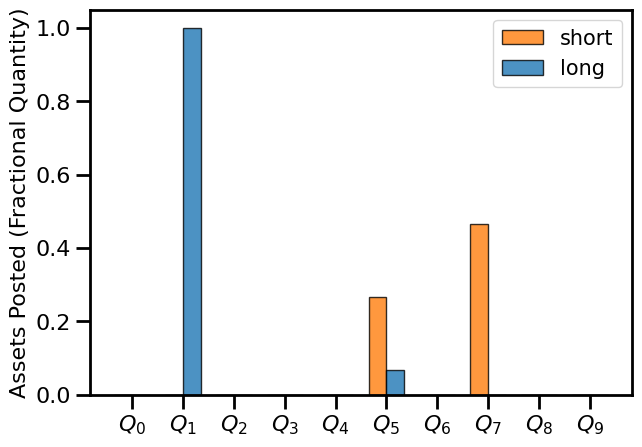

In [35]:
# Plotting
fig, ax = plt.subplots(figsize=(7,5))
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)


# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])
ax.set_ylabel("Assets Posted (Fractional Quantity)")
ax.legend()
fig.savefig("./Figures/assets_posted.png", bbox_inches="tight")

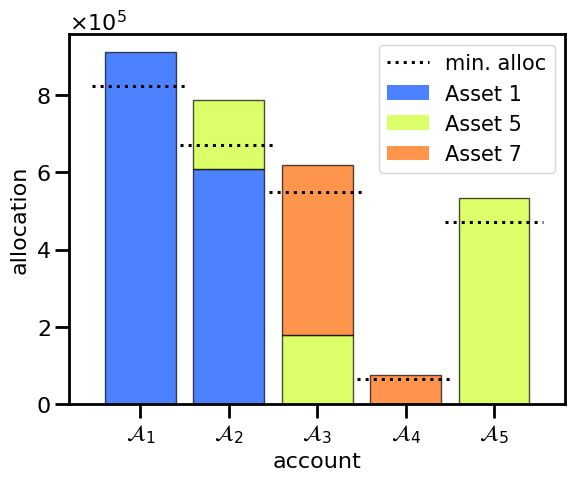

In [36]:
# Plotting

from matplotlib import colormaps
colors = colormaps["jet"]

fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_account))
assets_used = []
for j in sol_account.keys():
    sum_items = 0
    for i in sol_account[j].keys():
        if sol_account[j][i] > 0:
            ax.bar(
                j,
                sol_account[j][i],
                bottom=sum_items,
                color=colors((i+1) / n_assets),
                alpha=0.7,
                edgecolor="black",
            )
            assets_used.append(i)
            sum_items += sol_account[j][i]
            
for i in sorted(np.unique(assets_used)):
    ax.bar(0,0,color=colors((i+1) / n_assets), label=f"Asset {i}",alpha=0.7)
width  = 0.55
for j in sol_account.keys():
    ax.plot([j - width, j + width], [account_exposure[j],account_exposure[j]], linestyle=":", color="black")
ax.plot([], [], linestyle=":", color="black", label="min. alloc")
# # Adjust the x-axis tick positions and labels
ax.set_xticks(list(sol_account.keys()))
ax.set_xticklabels([r"$\mathcal{A}$" + f"$_{i+1}$" for i in sol_account.keys()])
ax.set_ylabel("allocation")
ax.set_xlabel("account")
# Apply the formatter to the y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 3))  # Adjust the power limits as needed

plt.gca().yaxis.set_major_formatter(formatter)
ax.legend()
fig.savefig("./Figures/allocation_v0.png", bbox_inches="tight")

## Correlated-Collateral Optimization

In [37]:
np.random.seed(1)
sigma = np.random.choice([-0.003, 0, 0.003], size=(n_assets, n_assets))
mdl = collateral_opt_2(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma, kind=kind)

mdl.solve()
sol = {name.name:round(value) for name, value in mdl.solution.as_dict().items()}
sol_alloc = solution_allocation(sol, n_binary, n_assets, n_accounts, account_duration, kind=kind)
sol_account = solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind=kind)

In [38]:
time_2 = []
cost_2 = []
np.random.seed(1)
sigma = np.random.choice([-0.003, 0, 0.003], size=(n_assets, n_assets))
for n_bin in range(1, n_binary+1):
    print(f"Num. bits {n_bin}")
    mdl = collateral_opt_2(n_bin, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma, kind=kind)
    it = time.time()
    mdl.solve()
    time_2.append(time.time() - it)
    cost_2.append(mdl.solution.objective_value)


Num. bits 1
Num. bits 2
Num. bits 3
Num. bits 4
Num. bits 5
Num. bits 6
Num. bits 7
Num. bits 8
Num. bits 9
Num. bits 10
Num. bits 11
Num. bits 12
Num. bits 13
Num. bits 14
Num. bits 15


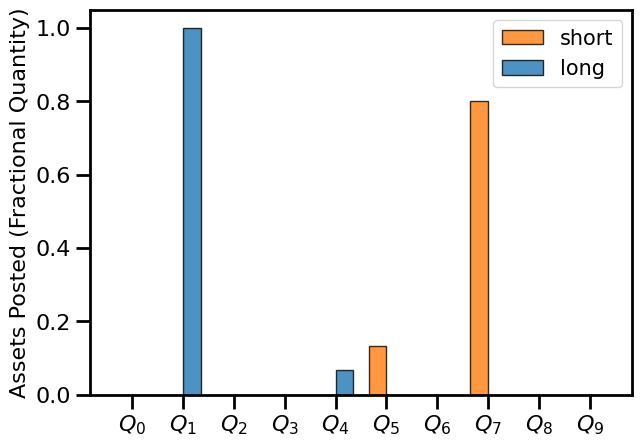

In [39]:
# Plotting
fig, ax = plt.subplots(figsize=(7,5))
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)


# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])
ax.set_ylabel("Assets Posted (Fractional Quantity)")
ax.legend()
fig.savefig("./Figures/assets_posted_v1.png", bbox_inches="tight")

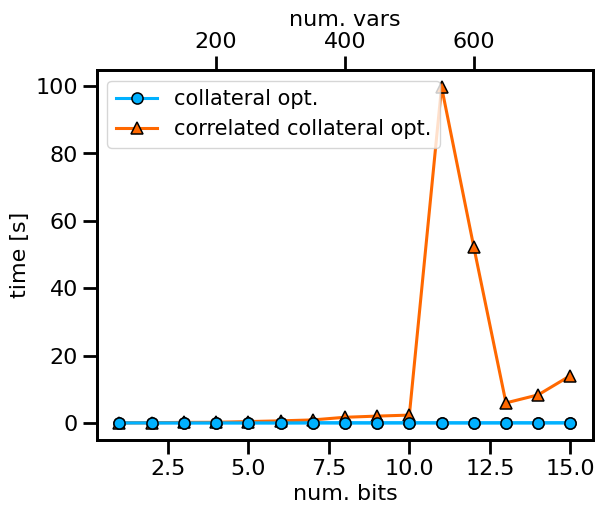

In [40]:
nbits = np.arange(1, n_binary+1)
nvars = n_assets * n_accounts * nbits

fig, ax = plt.subplots()
ax.plot(nbits, time_1, label="collateral opt.", marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
ax.plot(nbits, time_2, label="correlated collateral opt.", marker="^", markeredgecolor="black", markersize=8, color=colors(0.8))
ax.set_xlabel("num. bits")
ax.set_ylabel("time [s]")
ax.legend()
ax1 = ax.twiny()
ax1.plot(nvars, time_1, marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
# ax1.set_xlim(nvars[0], nvars[-1])
# ax1.set_xticks()
ax1.set_xlabel("num. vars")
fig.savefig("./Figures/time.png")

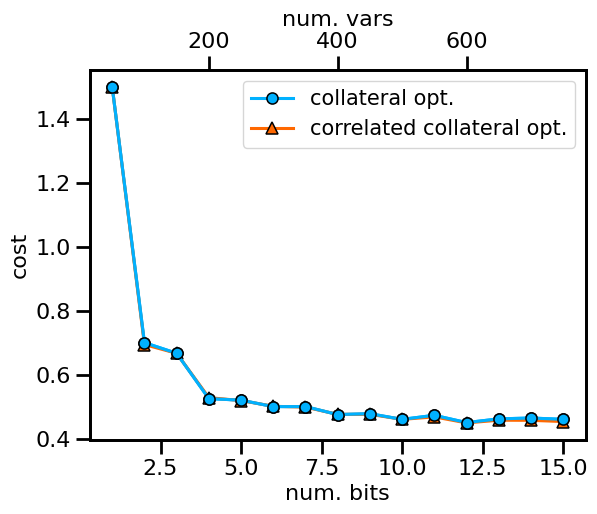

In [41]:
nbits = np.arange(1, n_binary+1)
nvars = n_assets * n_accounts * nbits

fig, ax = plt.subplots()
ax.plot(nbits, cost_1, label="collateral opt.", marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
ax.plot(nbits, cost_2, label="correlated collateral opt.", marker="^", markeredgecolor="black", markersize=8, color=colors(0.8))
ax.set_xlabel("num. bits")
ax.set_ylabel("cost")
ax.legend()
ax1 = ax.twiny()
ax1.plot(nvars, cost_1, marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
# ax1.set_xlim(nvars[0], nvars[-1])
# ax1.set_xticks()
ax1.set_xlabel("num. vars")
fig.savefig("./Figures/cost.png")

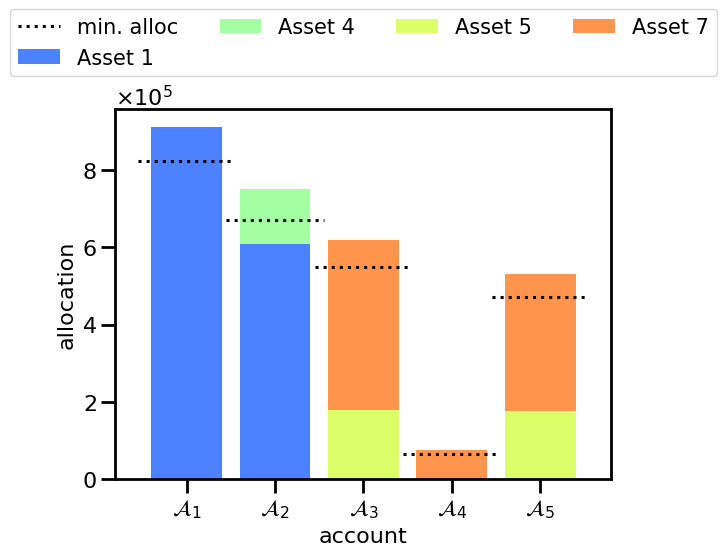

In [42]:
# Plotting
from matplotlib import colormaps
colors = colormaps["jet"]

fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_account))
assets_used = []
for j in sol_account.keys():
    sum_items = 0
    for i in sol_account[j].keys():
        if sol_account[j][i] > 0:
            ax.bar(
                j,
                sol_account[j][i],
                bottom=sum_items,
                color=colors((i+1) / n_assets),
                alpha=0.7,
            )
            assets_used.append(i)
            sum_items += sol_account[j][i]
width  = 0.55
            
for i in sorted(np.unique(assets_used)):
    ax.bar(0,0,color=colors((i+1) / n_assets), label=f"Asset {i}",alpha=0.7)
for j in sol_account.keys():
    ax.plot([j - width, j + width], [account_exposure[j],account_exposure[j]], linestyle=":", color="black")
ax.plot([], [], linestyle=":", color="black", label="min. alloc")
# # Adjust the x-axis tick positions and labels
ax.set_xticks(list(sol_account.keys()))
ax.set_xticklabels([r"$\mathcal{A}$" + f"$_{i+1}$" for i in sol_account.keys()])
ax.set_ylabel("allocation")
ax.set_xlabel("account")
# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=4)
fig.savefig("./Figures/allocation_v1.png", bbox_inches="tight")

# Small case QAOA

In [43]:
assets_used = [0,1,5,7]
accounts_used = [0,1,3]

assets_used = [1, 5 ,7]
accounts_used = [0, 2]
qaoa_data = {"CO":{}, "CCO":{}, "assets_used":assets_used, "accounts_used":accounts_used} #CO: collateral optimization CCO: Correlated collateral optimization

In [44]:

# Assets
asset_quantity = [pd.read_csv("data/sample_asset_quantity.csv", header=None)[0].values.tolist()[i] for i in assets_used]
asset_value = [pd.read_csv("data/sample_asset_value.csv", header=None)[0].values.tolist()[i] for i in assets_used]
asset_tiers = [pd.read_csv("data/sample_asset_tiers.csv", header=None)[0].values.tolist()[i] for i in assets_used]

n_assets = len(asset_quantity)

# Accounts /
account_exposure = [pd.read_csv("data/sample_account_exposure.csv", header=None)[0].values.tolist()[i] for i in accounts_used]
account_duration = [pd.read_csv("data/sample_account_duration.csv", header=None)[0].values.tolist()[i] for i in accounts_used]

n_accounts = len(account_exposure)

# Haircuts
haircuts = np.array(pd.read_csv("data/sample_haircuts.csv", header=None).values.tolist())[assets_used][:,accounts_used]

print(f"Num. assets: {n_assets}, num. accounts: {n_accounts}")

Num. assets: 3, num. accounts: 2


## Collateral Optimization: CPLEX solution

In [61]:
n_binary = 7
mdl = collateral_opt(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind)
mdl.solve()
sol_str = "".join(str(round(mdl.solution.get_value(xi))) for xi in mdl.iter_binary_vars())
sol = {name.name:value for name, value in mdl.solution.as_dict().items()}
sol_account = solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind)
print("Cost: ", get_cost(sol, n_binary, account_duration, asset_tiers, kind))
print("Satisfied all constriants 1: ", all([constraint_1(sol, i, n_accounts, n_binary,kind) for i in range(n_assets)]))
print("Satisfied all constriants 2: ", all([constraint_2(sol, j, n_assets, n_binary, asset_quantity,
          asset_value, haircuts, account_exposure, kind) for j in range(n_accounts)]))
cost_sol = mdl.objective_value

Cost:  0.25714285714285706
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True


In [62]:
mdl = collateral_opt(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind)
mdl.solve()
sol = {name.name:round(value) for name, value in mdl.solution.as_dict().items()}
sol_alloc = solution_allocation(sol, n_binary, n_assets, n_accounts, account_duration, kind)
sol_account = solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind)

In [63]:
time_1 = []
cost_1 = []
qaoa_data["CO"]["qubo"] = {}
qaoa_data["CO"]["sol"] = {}
qaoa_data["CO"]["ising"] = {}
for n_bin in range(1, n_binary+1):
    qaoa_data["CO"]["qubo"][n_bin] = {}
    qaoa_data["CO"]["sol"][n_bin] = {}
    qaoa_data["CO"]["ising"][n_bin] = {}
    for kk in range(1):
        mdl = collateral_opt(n_bin, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, kind)
        it = time.time()
        mdl.solve()
        time_1.append(time.time() - it)

        qaoa_data["CO"]["qubo"][n_bin][kk] = mdl
        qaoa_data["CO"]["sol"][n_bin][kk] = classical_solution(mdl, string=True)
        cost_1.append(mdl.solution.objective_value)
#         lambdas = [1, 1.7, 0.1, 1.5]
        lambdas = [0.143, 0.364, 0.117, 0.202]
        mdl_qubo = collateral_opt_unb(lambdas, n_bin, asset_quantity, asset_value,
                                 asset_tiers, account_exposure, account_duration, haircuts, kind)
        ising_hamiltonian = FromDocplex2IsingModel(mdl_qubo).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        qaoa_data["CO"]["ising"][n_bin][kk] = ising_hamiltonian
    
qaoa_data["CO"]["cplex_cost"] = cost_1
qaoa_data["CO"]["cplex_time"] = time_1

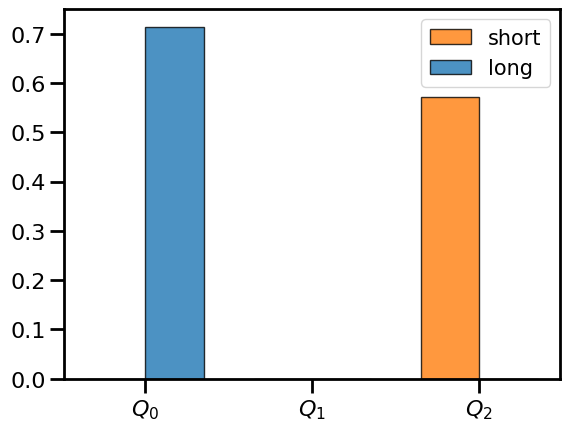

In [64]:
# Plotting
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)

# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])

ax.legend()

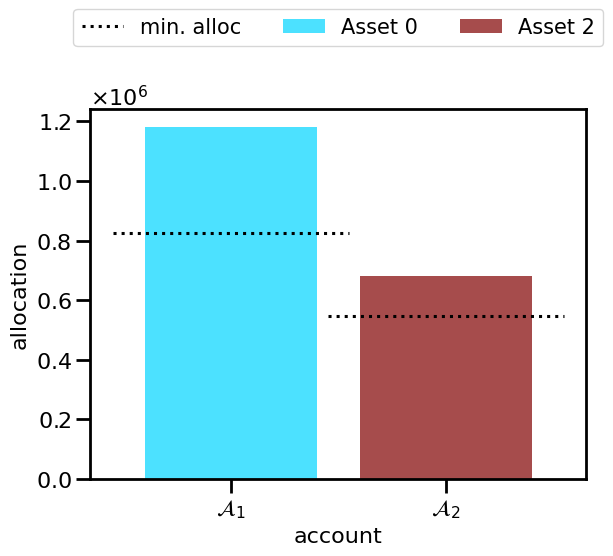

In [65]:
# Plotting
from matplotlib import colormaps
colors = colormaps["jet"]

fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_account))
assets_used = []
for j in sol_account.keys():
    sum_items = 0
    for i in sol_account[j].keys():
        if sol_account[j][i] > 0:
            ax.bar(
                j,
                sol_account[j][i],
                bottom=sum_items,
                color=colors((i+1) / n_assets),
                alpha=0.7,
            )
            assets_used.append(i)
            sum_items += sol_account[j][i]
width  = 0.55
            
for i in sorted(np.unique(assets_used)):
    ax.bar(0,0,color=colors((i+1) / n_assets), label=f"Asset {i}",alpha=0.7)
for j in sol_account.keys():
    ax.plot([j - width, j + width], [account_exposure[j],account_exposure[j]], linestyle=":", color="black")
ax.plot([], [], linestyle=":", color="black", label="min. alloc")
# # Adjust the x-axis tick positions and labels
ax.set_xticks(list(sol_account.keys()))
ax.set_xticklabels([r"$\mathcal{A}$" + f"$_{i+1}$" for i in sol_account.keys()])
ax.set_ylabel("allocation")
ax.set_xlabel("account")
# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=4)
fig.savefig("./Figures/QAOA/allocation_v1.png", bbox_inches="tight")

## Correlated Collateral Optimization

In [66]:
np.random.seed(1)
sigma = np.random.choice([-0.003, 0, 0.003], size=(n_assets, n_assets))
mdl = collateral_opt_2(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma, kind
        )

mdl.solve()
sol = {name.name:round(value) for name, value in mdl.solution.as_dict().items()}
sol_alloc = solution_allocation(sol, n_binary, n_assets, n_accounts, account_duration, kind)
sol_account = solution_account(sol, n_binary, asset_quantity, asset_value, haircuts, n_accounts, n_assets, kind)

In [70]:
time_2 = []
cost_2 = []
qaoa_data["CCO"]["qubo"] = {}
qaoa_data["CCO"]["sol"] = {}
qaoa_data["CCO"]["ising"] = {}
np.random.seed(1)
sigma = np.random.choice([-0.003, 0, 0.003], size=(n_assets, n_assets))
for n_bin in range(1, n_binary+1):
    qaoa_data["CCO"]["qubo"][n_bin] = {}
    qaoa_data["CCO"]["sol"][n_bin] = {}
    qaoa_data["CCO"]["ising"][n_bin] = {}
    for kk in range(1):
        print(f"Num. bits {n_bin}")
        mdl = collateral_opt_2(n_bin, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma, kind)
        it = time.time()
        mdl.solve()
        time_2.append(time.time() - it)
        cost_2.append(mdl.solution.objective_value)
        qaoa_data["CCO"]["qubo"][n_bin][kk] = mdl
        qaoa_data["CCO"]["sol"][n_bin][kk] = classical_solution(mdl)
        lambdas = [0.143, 0.364, 0.117, 0.202]
#         lambdas = [1, 1.7, 0.1, 1.5]
        mdl_qubo = collateral_opt_unb_2(lambdas, n_bin, asset_quantity, asset_value,
                                 asset_tiers, account_exposure, account_duration, haircuts, kind)
        ising_hamiltonian = FromDocplex2IsingModel(mdl_qubo).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        qaoa_data["CCO"]["ising"][n_bin][kk] = ising_hamiltonian
qaoa_data["CCO"]["cplex_cost"] = cost_2
qaoa_data["CCO"]["cplex_time"] = time_2

Num. bits 1


Num. bits 2
Num. bits 3
Num. bits 4
Num. bits 5
Num. bits 6
Num. bits 7


In [71]:
time_2

[0.005953073501586914,
 0.0038650035858154297,
 0.0069768428802490234,
 0.02112889289855957,
 0.020317792892456055,
 0.0388789176940918,
 0.01758885383605957]

In [55]:
np.save("./Data/qaoa_cases_hpc.npy", qaoa_data)
np.save("../Transfer_Learning_Different_COPs/Data/CO_6_42.npy", qaoa_data)

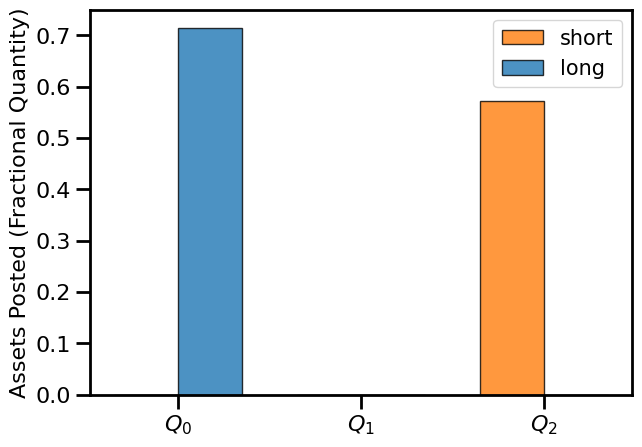

In [56]:
# Plotting
fig, ax = plt.subplots(figsize=(7,5))
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)


# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])
ax.set_ylabel("Assets Posted (Fractional Quantity)")
ax.legend()
fig.savefig("./Figures/QAOA/correlated_assets_posted_v1.png", bbox_inches="tight")

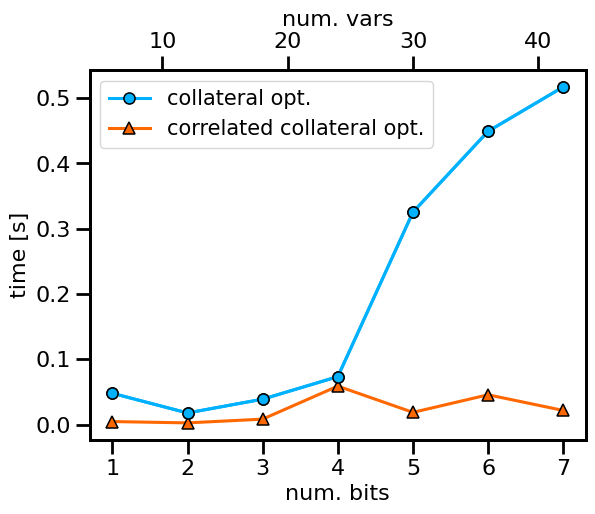

In [68]:
nbits = np.arange(1, n_binary+1)
nvars = n_assets * n_accounts * nbits

fig, ax = plt.subplots()
ax.plot(nbits, time_1, label="collateral opt.", marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
ax.plot(nbits, time_2, label="correlated collateral opt.", marker="^", markeredgecolor="black", markersize=8, color=colors(0.8))
ax.set_xlabel("num. bits")
ax.set_ylabel("time [s]")
ax.legend()
ax1 = ax.twiny()
ax1.plot(nvars, time_1, marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
# ax1.set_xlim(nvars[0], nvars[-1])
# ax1.set_xticks()
ax1.set_xlabel("num. vars")
fig.savefig("./Figures/QAOA/time.png", bbox_inches="tight")

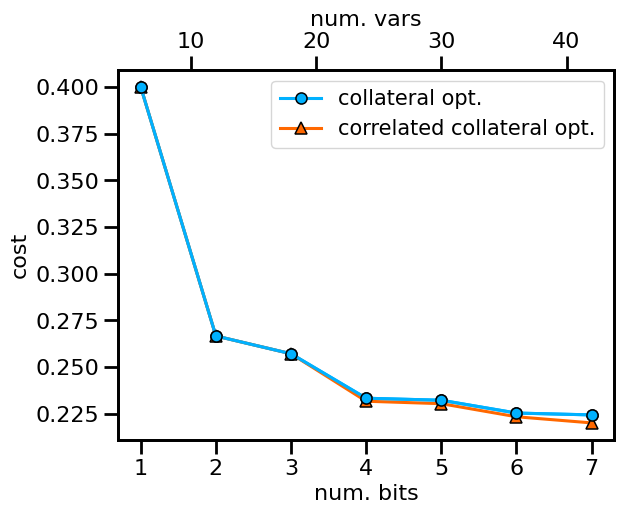

In [28]:
nbits = np.arange(1, n_binary+1)
nvars = n_assets * n_accounts * nbits

fig, ax = plt.subplots()
ax.plot(nbits, cost_1, label="collateral opt.", marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
ax.plot(nbits, cost_2, label="correlated collateral opt.", marker="^", markeredgecolor="black", markersize=8, color=colors(0.8))
ax.set_xlabel("num. bits")
ax.set_ylabel("cost")
ax.legend()
ax1 = ax.twiny()
ax1.plot(nvars, cost_1, marker="o", markeredgecolor="black", markersize=8, color=colors(0.3))
# ax1.set_xlim(nvars[0], nvars[-1])
# ax1.set_xticks()
ax1.set_xlabel("num. vars")
fig.savefig("./Figures/QAOA/cost.png", bbox_inches="tight")

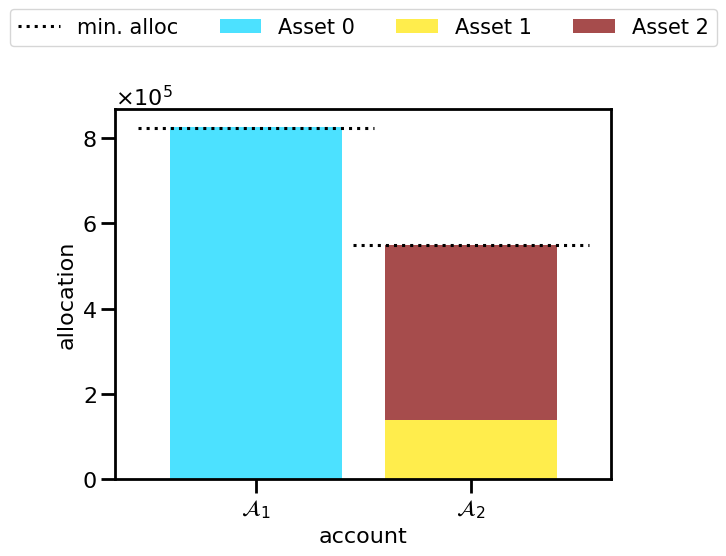

In [29]:
# Plotting
from matplotlib import colormaps
colors = colormaps["jet"]

fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_account))
assets_used = []
for j in sol_account.keys():
    sum_items = 0
    for i in sol_account[j].keys():
        if sol_account[j][i] > 0:
            ax.bar(
                j,
                sol_account[j][i],
                bottom=sum_items,
                color=colors((i+1) / n_assets),
                alpha=0.7,
            )
            assets_used.append(i)
            sum_items += sol_account[j][i]
width  = 0.55
            
for i in sorted(np.unique(assets_used)):
    ax.bar(0,0,color=colors((i+1) / n_assets), label=f"Asset {i}",alpha=0.7)
for j in sol_account.keys():
    ax.plot([j - width, j + width], [account_exposure[j],account_exposure[j]], linestyle=":", color="black")
ax.plot([], [], linestyle=":", color="black", label="min. alloc")
# # Adjust the x-axis tick positions and labels
ax.set_xticks(list(sol_account.keys()))
ax.set_xticklabels([r"$\mathcal{A}$" + f"$_{i+1}$" for i in sol_account.keys()])
ax.set_ylabel("allocation")
ax.set_xlabel("account")
# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=4)
fig.savefig("./Figures/QAOA/correlated_allocation_v1.png", bbox_inches="tight")

## unbalanced penalization

In [30]:
probs_total = np.zeros((10,10))
l1s_list = np.linspace(0.1 , 0.5, 10)
l2s_list = np.linspace(0.1, 2, 10)

for ii, l1 in enumerate(l1s_list):
    print(ii)
    for jj, l2 in enumerate(l2s_list):
        lambdas = [0.1, 0.14, l1, l2]
        beta0 = [0.797798564062, 0.790561216091, 0.565727413128, 0.418928198177, 0.357560695882, 0.327963039025,
                  0.278579924258, 0.191112071459, 0.138499127434, 0.088559369559]
        gamma0 = [0.076575807724, 0.163498015988, 0.366266724153, 0.58903005262, 0.704682555898, 0.759473376506, 
                  0.834549988049, 0.93527256568, 0.952963077941, 0.997679983915]
        params = {"betas":beta0, "gammas":gamma0}
        p = 10 #Number of layers
        n_binary = 2
        mdl = collateral_opt_unb(lambdas, n_binary, asset_quantity, asset_value,
                                 asset_tiers, account_exposure, account_duration, haircuts)
        qubo = FromDocplex2IsingModel(mdl)

        ising = qubo.ising_model
        max_weight = np.max(np.abs(ising.weights))
        ising.weights = [i/max_weight for i in ising.weights]
        qaoa = QAOA()
        qaoa.set_circuit_properties(p=p, init_type="custom", variational_params_dict=params)
        # qaoa.set_circuit_properties(p=p, init_type="ramp", linear_ramp_time=p) # initialization betas and gammas with a ramp technique
        qaoa.set_classical_optimizer(maxiter=1) 
        qaoa.compile(ising)
        qaoa.optimize()
        sol_str = qaoa_data["CO"]["sol"][n_binary][0][0]
        results = qaoa.result.lowest_cost_bitstrings(2 ** ising.n)

        for nn, string in enumerate(results["solutions_bitstrings"]):
            if string[:len(sol_str)] == sol_str:
                pos = nn
                break
        results["Eopt"] = results["bitstrings_energies"][nn]
        list_pos = []
        nq = ising.n
        for nn, ei in enumerate(results["bitstrings_energies"]):
            if ei == results["Eopt"]:
                list_pos.append(nn)
            elif ei > results["Eopt"]:
                break  
        results["opt_pos"] = list_pos # Optimal position in the sorted Hamiltonian
        results["probability"] = sum(np.array(results["probabilities"])[list_pos]) # Probability of the optimal solution
        results["classical_sol"] = sol_str # classical solution
        results["CoP"] = results["probability"] * 2 ** nq # Coefficient of Performance https://arxiv.org/abs/2211.13914
        results["Emin"] = np.min(results["bitstrings_energies"]) # minimum eigenvalue
        results["Emax"] = np.max(results["bitstrings_energies"]) # maximum eigenvalue
        results["Ef"] = np.min(qaoa.result.optimized["cost"]) # current average energy
        results["r"] = (results["Ef"] - results["Emax"])/(results["Emin"] - results["Emax"]) # Approximation ratio
        results["opt_angles"] = qaoa.result.optimized["angles"] # Optimal betas and gammas 
        results["num_qubits"] = nq
        results["ising_hamiltonian"] = ising
        results["cx"] = 2 * len([t for t in ising.terms if len(t) == 2]) * p
        probs_total[ii,jj] = results["probability"]

0
1
2
3
4
5
6
7
8
9


## Optimization of the lambda parameters

In [256]:
def cost_fun(lambdas):
    cost = 0
    lambdas = np.abs(lambdas)
    for n_i in range(1,4):
        beta0 = [0.797798564062, 0.790561216091, 0.565727413128, 0.418928198177, 0.357560695882, 0.327963039025,
                  0.278579924258, 0.191112071459, 0.138499127434, 0.088559369559]
        gamma0 = [0.076575807724, 0.163498015988, 0.366266724153, 0.58903005262, 0.704682555898, 0.759473376506, 
                  0.834549988049, 0.93527256568, 0.952963077941, 0.997679983915]
        params = {"betas":beta0, "gammas":gamma0}
        p = 10 #Number of layers
        n_binary = n_i
        mdl = collateral_opt_unb(lambdas, n_binary, asset_quantity, asset_value,
                                 asset_tiers, account_exposure, account_duration, haircuts)
        qubo = FromDocplex2IsingModel(mdl)

        ising = qubo.ising_model
        max_weight = np.max(np.abs(ising.weights))
        ising.weights = [i/max_weight for i in ising.weights]
        qaoa = QAOA()
        qaoa.set_circuit_properties(p=p, init_type="custom", variational_params_dict=params)
        # qaoa.set_circuit_properties(p=p, init_type="ramp", linear_ramp_time=p) # initialization betas and gammas with a ramp technique
        qaoa.set_classical_optimizer(maxiter=1) 
        qaoa.compile(ising)
        qaoa.optimize()
        sol_str = qaoa_data["CO"]["sol"][n_binary][0][0]
        results = qaoa.result.lowest_cost_bitstrings(2 ** ising.n)

        for nn, string in enumerate(results["solutions_bitstrings"]):
            if string[:len(sol_str)] == sol_str:
                pos = nn
                break
        results["Eopt"] = results["bitstrings_energies"][nn]
        list_pos = []
        nq = ising.n
        for nn, ei in enumerate(results["bitstrings_energies"]):
            if ei == results["Eopt"]:
                list_pos.append(nn)
            elif ei > results["Eopt"]:
                break  
        results["opt_pos"] = list_pos # Optimal position in the sorted Hamiltonian
        results["probability"] = sum(np.array(results["probabilities"])[list_pos]) # Probability of the optimal solution
        results["classical_sol"] = sol_str # classical solution
        results["CoP"] = results["probability"] * 2 ** nq # Coefficient of Performance https://arxiv.org/abs/2211.13914
        results["Emin"] = np.min(results["bitstrings_energies"]) # minimum eigenvalue
        results["Emax"] = np.max(results["bitstrings_energies"]) # maximum eigenvalue
        results["Ef"] = np.min(qaoa.result.optimized["cost"]) # current average energy
        results["r"] = (results["Ef"] - results["Emax"])/(results["Emin"] - results["Emax"]) # Approximation ratio
        results["opt_angles"] = qaoa.result.optimized["angles"] # Optimal betas and gammas 
        results["num_qubits"] = nq
        results["ising_hamiltonian"] = ising
        results["cx"] = 2 * len([t for t in ising.terms if len(t) == 2]) * p
        cost -= results["CoP"]
        print(f"CoP {nq}: {results['CoP']} | {[round(i,3) for i in lambdas]}")
    return cost

In [257]:
from scipy.optimize import minimize
x0 = [1, 1.7, 0.1, 1.5]
# x0 = [0.186, 0.41, 0.185, 0.286] #COP 56, 115
x0 = [0.143, 0.364, 0.117, 0.202] #COP 55, 133
sol_f = minimize(cost_fun, x0 = x0)

CoP 6: 55.11142015808887 | [0.143, 0.364, 0.117, 0.202]
CoP 12: 132.95837761272668 | [0.143, 0.364, 0.117, 0.202]
CoP 18: 277.05118419592185 | [0.143, 0.364, 0.117, 0.202]
CoP 6: 55.11141976500088 | [0.143, 0.364, 0.117, 0.202]
CoP 12: 132.95837529040162 | [0.143, 0.364, 0.117, 0.202]
CoP 18: 277.0511800077136 | [0.143, 0.364, 0.117, 0.202]
CoP 6: 55.11142016154487 | [0.143, 0.364, 0.117, 0.202]
CoP 12: 132.95837732111278 | [0.143, 0.364, 0.117, 0.202]
CoP 18: 277.05118233016304 | [0.143, 0.364, 0.117, 0.202]
CoP 6: 55.11142060472711 | [0.143, 0.364, 0.117, 0.202]
CoP 12: 132.95837480167384 | [0.143, 0.364, 0.117, 0.202]
CoP 18: 277.0511784113006 | [0.143, 0.364, 0.117, 0.202]
CoP 6: 55.11142074629509 | [0.143, 0.364, 0.117, 0.202]
CoP 12: 132.95837763304777 | [0.143, 0.364, 0.117, 0.202]
CoP 18: 277.05117869117595 | [0.143, 0.364, 0.117, 0.202]
CoP 6: 58.71612229291743 | [0.441, 0.182, 0.572, 0.212]
CoP 12: 16.146276454626054 | [0.441, 0.182, 0.572, 0.212]
CoP 18: 45.64170213976364 | 

KeyboardInterrupt: 

In [216]:
print(f"optimal: x {l2s_list[np.argmax(probs_total)//len(l2s_list)]} y {l1s_list[np.argmax(probs_total)%len(l1s_list)]}")

optimal: x 0.1 y 0.1


In [213]:
print(f"optimal: x {l2s_list[np.argmax(probs_total)//len(l2s_list)]} y {l1s_list[np.argmax(probs_total)%len(l1s_list)]}")

optimal: x 1.3666666666666667 y 0.14444444444444446


In [205]:
probs_total*2**nq

array([[8.88922662e-03, 1.12428643e-02, 1.58113992e+00, 1.24483627e+01,
        2.44827859e+01, 2.89026161e+01, 2.81628492e+01, 2.60920373e+01,
        2.39848827e+01, 2.20600747e+01],
       [1.45145997e-02, 6.75092427e-02, 1.27676366e+00, 1.68432127e+01,
        2.80114437e+01, 3.10531043e+01, 2.95386981e+01, 2.71706782e+01,
        2.48305748e+01, 2.26312906e+01],
       [1.71074740e-02, 3.02449092e-02, 1.66451231e-01, 1.42870278e+01,
        2.67331595e+01, 3.10575804e+01, 3.03445622e+01, 2.81563372e+01,
        2.56055778e+01, 2.30753595e+01],
       [6.82590067e-03, 3.39386506e-01, 1.67340616e-01, 6.40226456e+00,
        2.15969683e+01, 2.98875508e+01, 3.10726682e+01, 2.91584889e+01,
        2.62903362e+01, 2.33827060e+01],
       [9.80586330e-03, 6.73869213e-01, 6.07289232e-01, 2.31266195e+00,
        1.51557877e+01, 2.78456903e+01, 3.15338345e+01, 3.00818192e+01,
        2.68735615e+01, 2.36287641e+01],
       [1.07036821e-01, 4.35514503e-01, 3.48352702e-01, 7.60720831e-01,
   

[Text(0, 0, '0.1'), Text(0, 9, '0.5')]

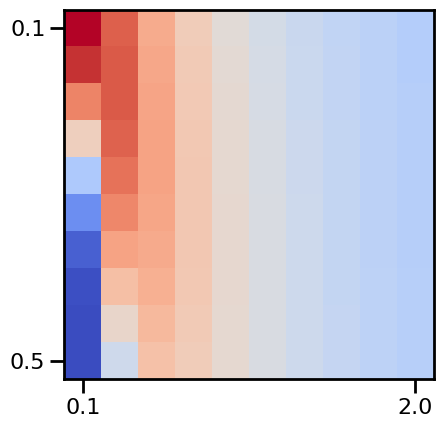

In [217]:
fig, ax = plt.subplots()
ax.imshow(probs_total, cmap="coolwarm")
ax.set_xticks([0,len(l2s_list)-1])
ax.set_yticks([0,len(l1s_list)-1])
ax.set_xticklabels([l2s_list[0], l2s_list[-1]])
ax.set_yticklabels([l1s_list[0], l1s_list[-1]])


[Text(0, 0, '-1.0'), Text(0, 9, '0.1')]

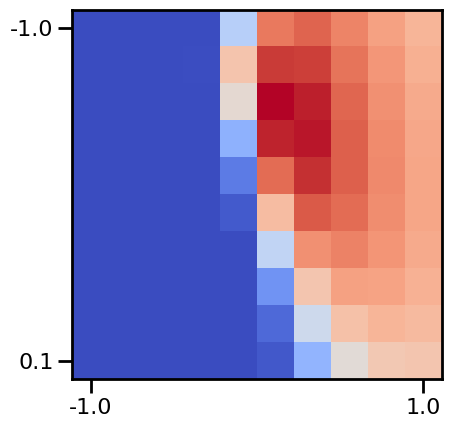

In [198]:
fig, ax = plt.subplots()
ax.imshow(probs_total, cmap="coolwarm")
ax.set_xticks([0,len(l2s_list)-1])
ax.set_yticks([0,len(l1s_list)-1])
ax.set_xticklabels([l2s_list[0], l2s_list[-1]])
ax.set_yticklabels([l1s_list[0], l1s_list[-1]])


In [32]:
sol_qaoa = {x.name:int(results["solutions_bitstrings"][0][i]) for i, x in enumerate(mdl.iter_binary_vars())}
sol_alloc = solution_allocation(sol_qaoa, n_binary)
print("Cost: ", get_cost(sol_qaoa, n_binary, account_duration, asset_tiers))
print("Satisfied all constriants 1: ", all([constraint_1(sol_qaoa, i, n_accounts, n_binary) for i in range(n_assets)]))
print("Satisfied all constriants 2: ", all([constraint_2(sol_qaoa, j, n_assets, n_binary, asset_quantity,
          asset_value, haircuts, account_exposure) for j in range(n_accounts)]))
print(f"CoP: {results['CoP']}")
print(f"probability finding optimal solution: {100*results['probability']}%")

Cost:  0.2666666666666666
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
CoP: 47.87114497152212
probability finding optimal solution: 1.1687291252813017%


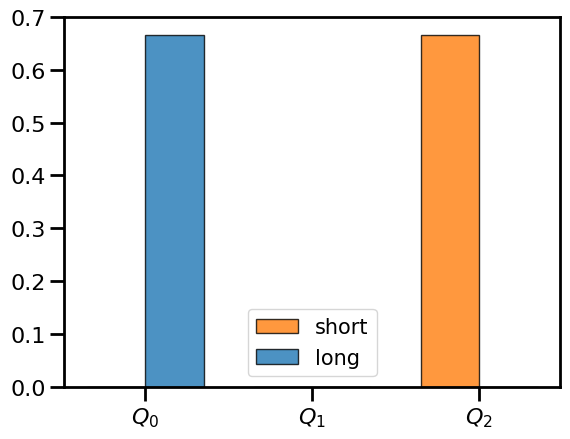

In [33]:
# Plotting
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)

# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])

ax.legend()

# Adding correlation between assets in Collateral optimization

$$\min \sum_i^{n}\sum_j^m \Omega_{ij}Q_{ij} + \sum_j^m \sum_i^{n}\sum_{k>i}^{n}\sigma_{ik}Q_{ij}Q_{kj}$$

where $\sigma_{ik}$ is a correlation matrix that for simplicity in our problem will have three values $\sigma_{ik} \in \{-0.001,0,0.001\}$, $-1$ if both assets want to be together, $0$ if they are not correlated and $1$ if they do not want to be together.

In [360]:
def collateral_opt_2(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * Q[k][j][bk] * Q[i][j][bi]
    mdl.minimize(cost)

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        mdl.add_constraint(mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)) <= 1)
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
#         val = np.mean([v*q for v, q in zip(asset_value,asset_quantity)])
        mdl.add_constraint(mdl.sum(bin_coef[b]*asset_quantity[i]*asset_value[i]*
                                   (haircuts[i][j]/100)* Q[i][j][b]/account_exposure[j]
                                   for b in range(n_binary) for i in range(n_assets)) >= 1)
    return mdl

def collateral_opt_unb_2(lambdas, n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma):
    n_assets = len(asset_quantity)
    n_accounts = len(account_exposure)
    
    # Updated Tier list 
    Omega = np.zeros(shape=(n_assets, n_accounts))

    for i in range(n_assets):
        for j in range(n_accounts):
            Omega[i,j] = abs(account_duration[j] - asset_tiers[i])

    mdl = Model("Collateral_Opt")
    bin_coef = [2**n/(2**n_binary - 1) for n in range(n_binary)]

    Q = [[[mdl.binary_var(f"Q_{i}_{j}^{b}") for b in range(n_binary)] for j in range(n_accounts)] for i in range(n_assets)]
    cost  = 0
    for i in range(n_assets):
        for j in range(n_accounts):
            for b in range(n_binary):
                cost += bin_coef[b] * (Omega[i][j]) * Q[i][j][b]
    # Adding the correlation between the assets
    for j in range(n_accounts):
        for i in range(n_assets):
            for k in range(i+1, n_assets):
                for bi in range(n_binary):
                    for bk in range(n_binary):
                        cost += sigma[i][k] * Q[k][j][bk] * Q[i][j][bi]

    # First constraint: no asset is distributed to the accounts beyond unity
    for i in range(n_assets):
        h1 = (1 - mdl.sum(bin_coef[b]* Q[i][j][b] for b in range(n_binary) for j in range(n_accounts)))
        cost -= lambdas[0] * h1
        cost += lambdas[1] * h1**2
    # second constraint: the requirement constraint that enforces that we allocate a suitable value such that the lender’s loan is secured
    for j in range(n_accounts):
        h2 = (mdl.sum(min(bin_coef[b]*asset_quantity[i]*asset_value[i]/account_exposure[j], 1)*
                           (haircuts[i][j]/100) * Q[i][j][b]
                           for b in range(n_binary) for i in range(n_assets)) - 1)
        cost -= lambdas[2] * h2
        cost += lambdas[3] * h2 ** 2
    mdl.minimize(cost)
    return mdl

## CPLEX solution 

In [361]:
n_binary = 1
np.random.seed(123)
sigma = np.random.choice([-1, 0, 1], size=(n_assets, n_assets))
mdl = collateral_opt_2(n_binary, asset_quantity, asset_value, asset_tiers, account_exposure, account_duration, haircuts, sigma)
mdl.solve()
sol_str = "".join(str(round(mdl.solution.get_value(xi))) for xi in mdl.iter_binary_vars())
sol = {name.name:value for name, value in mdl.solution.as_dict().items()}
sol_alloc = solution_allocation(sol, n_binary)
sol_account = solution_account()
print("Cost: ", get_cost(sol, n_binary, account_duration, asset_tiers))
print("Satisfied all constriants 1: ", all([constraint_1(sol, i, n_accounts, n_binary) for i in range(n_assets)]))
print("Satisfied all constriants 2: ", all([constraint_2(sol, j, n_assets, n_binary, asset_quantity,
          asset_value, haircuts, account_exposure) for j in range(n_accounts)]))
cost_sol = mdl.objective_value

Cost:  0.6
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True


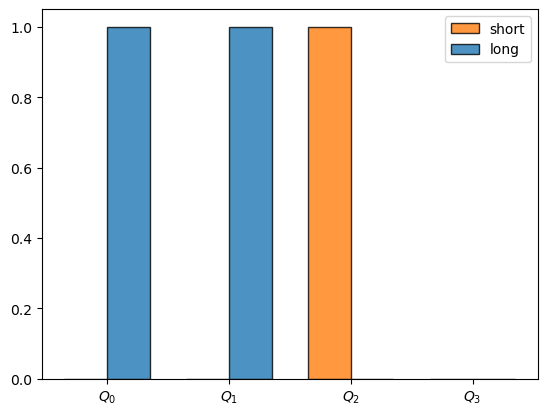

In [362]:
# Plotting
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Calculate the position for each account
positions = range(len(sol_alloc["short"]))

# Plotting the "short" bars
ax.bar(positions, sol_alloc["short"].values(), width, label="short", color="tab:orange", edgecolor="black", alpha=0.8)

# Plotting the "long" bars next to the "short" bars
ax.bar([p + width for p in positions], sol_alloc["long"].values(), width, label="long", color="tab:blue", edgecolor="black", alpha=0.8)

# Adjust the x-axis tick positions and labels
ax.set_xticks([p + width/2 for p in positions])
ax.set_xticklabels([f"${i}$" for i in sol_alloc["short"].keys()])

ax.legend()

## Unbalanced penalization

In [366]:
lambdas = [1,1.7,1,10]
beta0 = [0.797798564062, 0.790561216091, 0.565727413128, 0.418928198177, 0.357560695882, 0.327963039025,
          0.278579924258, 0.191112071459, 0.138499127434, 0.088559369559]
gamma0 = [0.076575807724, 0.163498015988, 0.366266724153, 0.58903005262, 0.704682555898, 0.759473376506, 
          0.834549988049, 0.93527256568, 0.952963077941, 0.997679983915]
params = {"betas":beta0, "gammas":gamma0}
p = 10 #Number of layers
n_binary = 1
mdl = collateral_opt_unb_2(lambdas, n_binary, asset_quantity, asset_value,
                         asset_tiers, account_exposure, account_duration, haircuts, sigma)
qubo = FromDocplex2IsingModel(mdl)

ising = qubo.ising_model
max_weight = np.max(np.abs(ising.weights))
ising.weights = [i/max_weight for i in ising.weights]
qaoa = QAOA()
qaoa.set_circuit_properties(p=p, init_type="custom", variational_params_dict=params)
# qaoa.set_circuit_properties(p=p, init_type="ramp", linear_ramp_time=p) # initialization betas and gammas with a ramp technique
qaoa.set_classical_optimizer(maxiter=1000) 
qaoa.compile(ising)
qaoa.optimize()

In [367]:
results = qaoa.result.lowest_cost_bitstrings(2 ** ising.n)
for nn, string in enumerate(results["solutions_bitstrings"]):
    if string[:len(sol_str)] == sol_str:
        pos = nn
        break
results["Eopt"] = results["bitstrings_energies"][nn]
list_pos = []
nq = ising.n
for nn, ei in enumerate(results["bitstrings_energies"]):
    if ei == results["Eopt"]:
        list_pos.append(nn)
    elif ei > results["Eopt"]:
        break  
results["opt_pos"] = list_pos # Optimal position in the sorted Hamiltonian
results["probability"] = sum(np.array(results["probabilities"])[list_pos]) # Probability of the optimal solution
results["classical_sol"] = sol_str # classical solution
results["CoP"] = results["probability"] * 2 ** nq # Coefficient of Performance https://arxiv.org/abs/2211.13914
results["Emin"] = np.min(results["bitstrings_energies"]) # minimum eigenvalue
results["Emax"] = np.max(results["bitstrings_energies"]) # maximum eigenvalue
results["Ef"] = np.min(qaoa.result.optimized["cost"]) # current average energy
results["r"] = (results["Ef"] - results["Emax"])/(results["Emin"] - results["Emax"]) # Approximation ratio
results["opt_angles"] = qaoa.result.optimized["angles"] # Optimal betas and gammas 
results["num_qubits"] = nq
results["ising_hamiltonian"] = ising
results["cx"] = 2 * len([t for t in ising.terms if len(t) == 2]) * p

In [368]:
sol_qaoa = {x.name:int(results["solutions_bitstrings"][0][i]) for i, x in enumerate(mdl.iter_binary_vars())}
sol_alloc = solution_allocation(sol_qaoa, n_binary)
print("Cost: ", get_cost(sol_qaoa, n_binary, account_duration, asset_tiers))
print("Satisfied all constriants 1: ", all([constraint_1(sol_qaoa, i, n_accounts, n_binary) for i in range(n_assets)]))
print("Satisfied all constriants 2: ", all([constraint_2(sol_qaoa, j, n_assets, n_binary, asset_quantity,
          asset_value, haircuts, account_exposure) for j in range(n_accounts)]))
print(f"CoP: {results['CoP']}")
print(f"probability finding optimal solution: {100*results['probability']}%")

Cost:  0.6
Satisfied all constriants 1:  True
Satisfied all constriants 2:  True
CoP: 39.161722586289656
probability finding optimal solution: 15.297547885269397%


/Users/alejomonbar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


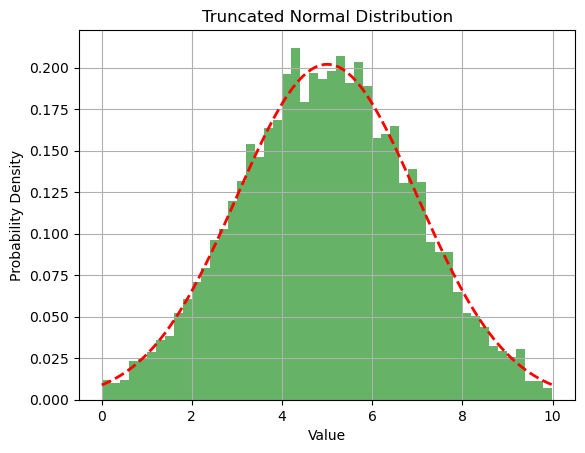

In [1]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# Set the limits for the normal distribution
lower_limit = 0
upper_limit = 10

# Set the mean and standard deviation of the normal distribution
mean = 5
std_dev = 2

# Calculate the parameters for the truncated normal distribution
a = (lower_limit - mean) / std_dev
b = (upper_limit - mean) / std_dev

# Generate random numbers from the truncated normal distribution
random_numbers = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=10000)

# Plot the histogram of the generated data
plt.hist(random_numbers, bins=50, density=True, alpha=0.6, color='g')

# Plot the standard normal distribution for comparison
x = np.linspace(lower_limit, upper_limit, 100)
y = truncnorm.pdf(x, a, b, loc=mean, scale=std_dev)
plt.plot(x, y, 'r--', linewidth=2)

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Truncated Normal Distribution')
plt.grid(True)
plt.show()
